In [ ]:
import sys
!{sys.executable} -m pip install datasets

     |████████████████████████████████| 311 kB 5.1 MB/s 
     |████████████████████████████████| 243 kB 9.5 MB/s 
     |████████████████████████████████| 133 kB 22.8 MB/s 
     |████████████████████████████████| 67 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 30.3 MB/s 
     |████████████████████████████████| 271 kB 32.5 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 144 kB 37.0 MB/s 


In [ ]:
from datasets import load_dataset
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from itertools import chain
from collections import Counter


#pour la visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display


#pour les modèles
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

#import the metrics class pour la mesure des performances au moment de l'évaluation
from sklearn import metrics
from sklearn import svm

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

# Première méthode

**Train et test data**

In [ ]:
train = load_dataset('allocine', split="train")
test = load_dataset('allocine', split="test")

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/866 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/66.6M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset allocine_dataset downloaded and prepared to /root/.cache/huggingface/datasets/allocine_dataset/allocine/1.0.0/91f700d606838c22c5c370846746e60503219d0c1f16ed96bfd1fa19a73458eb. Subsequent calls will reuse this data.


Reusing dataset allocine_dataset (/root/.cache/huggingface/datasets/allocine_dataset/allocine/1.0.0/91f700d606838c22c5c370846746e60503219d0c1f16ed96bfd1fa19a73458eb)


**Critiques positives et négatives de l'ensemble de train**

In [ ]:
all_positive = []
all_negative = []
for k in range(len(train)):
  label = train[k]["label"]
  review = train[k]["review"]
  if label==0:
    all_negative.append(review)
  else:
    all_positive.append(review)

**tokenizer et stop words**

In [ ]:
from nltk.tokenize.casual import TweetTokenizer
t = TweetTokenizer()
stop_words_fr = stopwords.words('french')
exclude_ponctuation = set(string.punctuation)
stop_words_fr.extend(exclude_ponctuation)
stop_words_fr.extend(["...","’"])

In [ ]:
def tok_sentence(sentence):
  res = []
  res.extend(t.tokenize(sentence.lower()))
  res = [word for word in res if word not in stop_words_fr]
  return res

In [ ]:
def word_feats(sentence):
  tokens = tok_sentence(sentence)
  return dict([(word, True) for word in tokens])

In [ ]:
pos_feats = [(word_feats(review), 'positive') for review in all_positive]
neg_feats = [(word_feats(review), 'negative') for review in all_negative]

**modèle**

In [ ]:
from nltk.classify import NaiveBayesClassifier

**train**

In [ ]:
trainfeats = pos_feats + neg_feats
classifier = NaiveBayesClassifier.train(trainfeats)

**test**

In [ ]:
test_review = []
test_label = []
for k in range(len(test)):
  review = test[k]["review"]
  label = test[k]["label"]
  test_review.append(review)
  test_label.append(label)

**predictions**

In [ ]:
predictions = []
for k in range(len(test)):
  pred = classifier.classify(word_feats(test_review[k]))
  predictions.append(pred)

In [ ]:
predictions = [1 if value=='positive' else 0 for value in predictions]

In [ ]:
test_label = np.array(test_label)
predictions = np.array(predictions)

In [ ]:
correct = (predictions == test_label)
accuracy = correct.sum() / correct.size

**accuracy**

In [ ]:
accuracy

0.8946

In [ ]:
print(classifier.classify(word_feats('le film est très intéressant')))

positive


# Deuxième méthode

In [ ]:
train = load_dataset('allocine', split="train")
test = load_dataset('allocine', split="test")

Reusing dataset allocine_dataset (/root/.cache/huggingface/datasets/allocine_dataset/allocine/1.0.0/91f700d606838c22c5c370846746e60503219d0c1f16ed96bfd1fa19a73458eb)
Reusing dataset allocine_dataset (/root/.cache/huggingface/datasets/allocine_dataset/allocine/1.0.0/91f700d606838c22c5c370846746e60503219d0c1f16ed96bfd1fa19a73458eb)


In [ ]:
def to_df(data):
  data_review = []
  data_label = []
  for k in range(len(data)):
    review = data[k]["review"]
    label = data[k]["label"]
    data_review.append(review)
    data_label.append(label)
  df = pd.DataFrame({'Review': data_review, 'Label': data_label})
  return df

fct pour transformer le dictionnaire en dataframe

In [ ]:
train = to_df(train)
test = to_df(test)

In [ ]:
def split(data,k):
  chosen_idx = np.sort(np.random.choice(len(data), replace = False, size = k) )
  data= data.iloc[chosen_idx] 
  data.sort_index(axis = 0, ascending = True)
  data.index=range(k)
  return data

In [ ]:
train = split(train,7000)

## Statistique obtenues sans Lémmatisation, nettoyage et tokénisation

on travaille sur un sous-échantillon de notre dataset d'apprentissage pour que le train de notre modèle soit possible sans soucis dans google colab

In [ ]:
train.Label.value_counts()

0    3518
1    3482
Name: Label, dtype: int64

la classe la plus fréquente est 1 (positif) 2519 critiques

In [ ]:
#fréquence de distribution entre les critiques positives et négatives de l'enssemble d'entraînement
print(pd.crosstab(index=train["Label"],columns="count"))

col_0  count
Label       
0       3518
1       3482


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


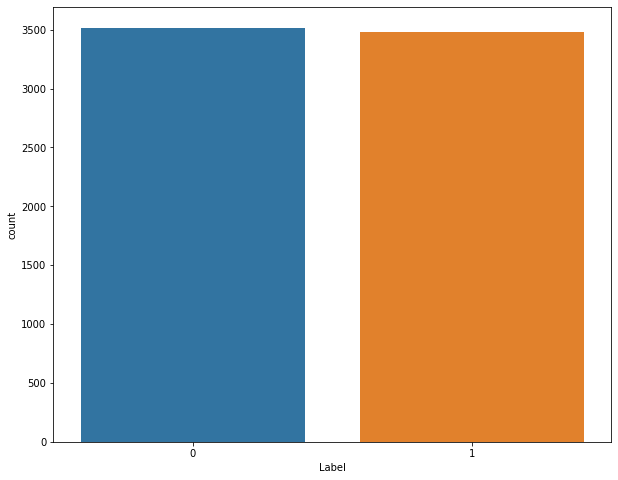

In [ ]:
plot , ax = plt.subplots(figsize=(10,8))
sns.countplot(train["Label"])

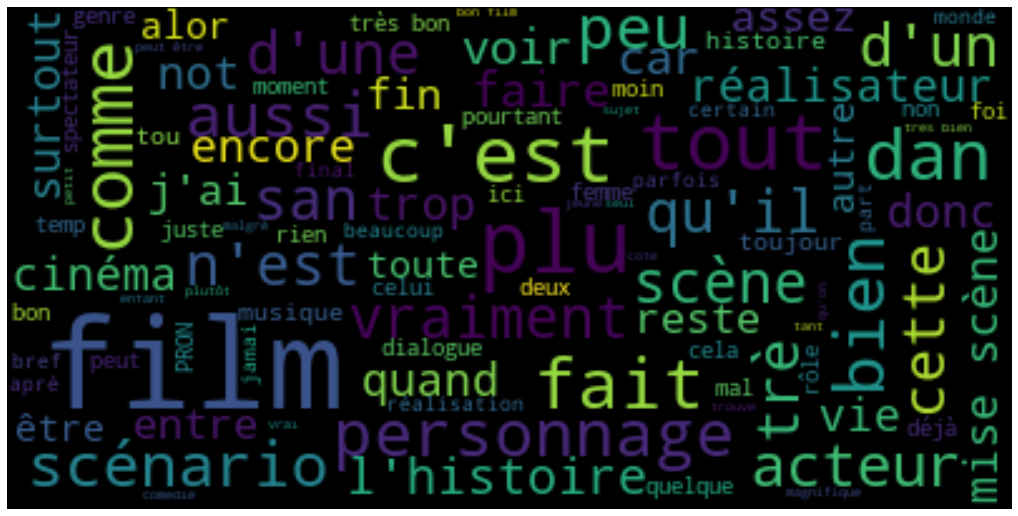

In [ ]:
text = " ".join(review for review in train.Review)


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black", stopwords=stopwords.words('french')).generate(text)
plt.figure(figsize=(18,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();


In [ ]:
#fréquence de distribution entre les critiques positives et négatives de l'enssemble de test
print(pd.crosstab(index=test["Label"],columns="count"))

col_0  count
Label       
0      10408
1       9592


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


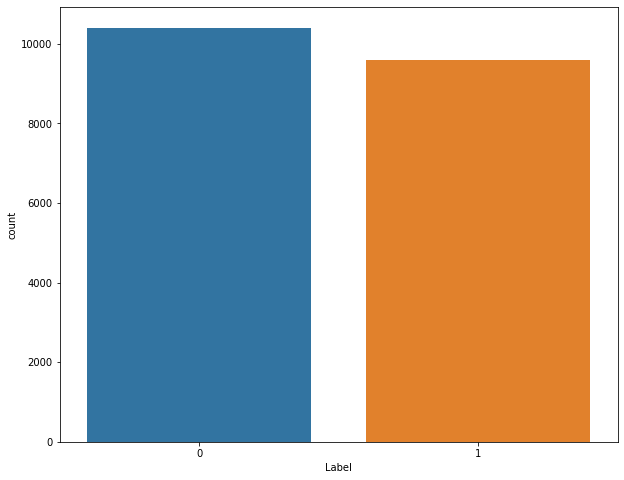

In [ ]:
plot , ax = plt.subplots(figsize=(10,8))
sns.countplot(test["Label"])

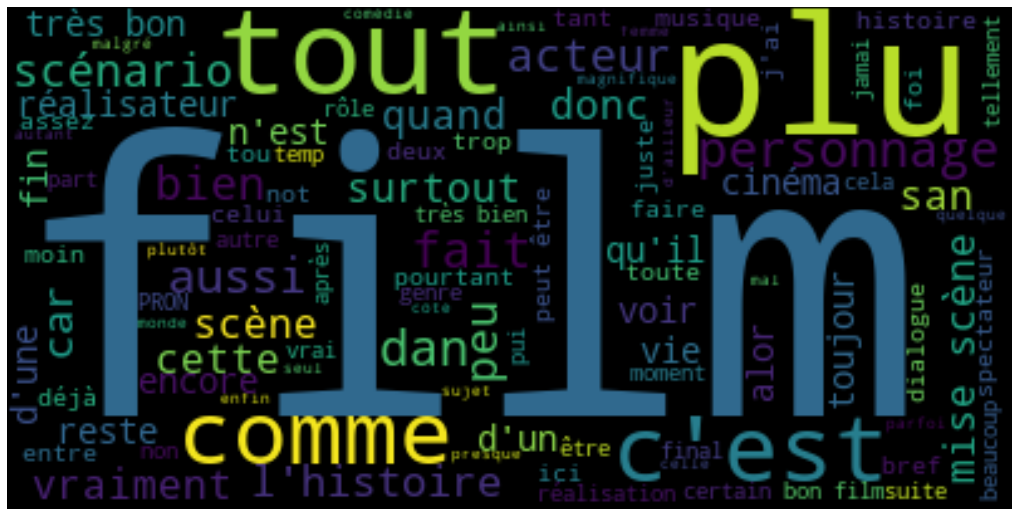

In [ ]:
text = " ".join(review for review in test.Review)


wordcloud = WordCloud(max_font_size=150, max_words=100, background_color="black", stopwords=stopwords.words('french')).generate(text)
plt.figure(figsize=(18,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();



## Tokeniser, nettoyer et lemmatiser grâce à Spacy.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def normalize_text(txt):
    txt = txt.replace("’", "'")
    txt = re.sub(r"'([ ]+)", r"'", txt)
    txt = re.sub(r"([ ]+)'", r"'", txt)
    txt = re.sub(r"-([ ]+)", r"-", txt)
    txt = re.sub(r"([ ]+)-", r"-", txt)
    txt = re.sub(r"([ ]+)", r" ", txt)
    txt = re.sub(r"([ ]+)$", r"", txt)
    txt = txt.replace("\n", "")
    txt = txt.replace("...", "")
    return txt.strip()

def tokenisation_lemma_spacy(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le texte de chaque token
    return [X.lemma_ for X in doc]

def clean_text(text, stopword):
    #On met en minuscule la phrase qu'on veut tokeniser afin de ne pas avoir de soucis par la suite
    token_lemma = tokenisation_lemma_spacy(normalize_text(text.lower()))
    text_without_stopword = [word for word in token_lemma if (len(word))>2 and word not in stopword]
    return ' '.join(text_without_stopword)

In [ ]:
#On télécharge la notion de stopword pour français de nltk
exclude_ponctuation = set(string.punctuation)
stop_french=stopwords.words('french')
stop_french.extend(exclude_ponctuation)



In [ ]:
train["Review"] = train["Review"].apply(lambda contenu: clean_text(contenu, stop_french))
test["Review"] = test["Review"].apply(lambda contenu: clean_text(contenu, stop_french))

#### fréquence de distribution et nuage de mots  du train

In [ ]:
#fréquence de distribution entre les critiques positives et négatives de l'enssemble d'entraînement
print(pd.crosstab(index=train["Label"],columns="count"))


col_0  count
Label       
0       3518
1       3482


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


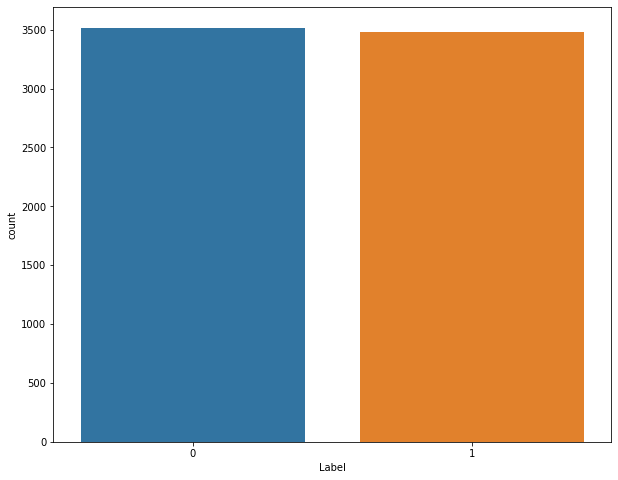

In [ ]:
plot , ax = plt.subplots(figsize=(10,8))
sns.countplot(train["Label"])

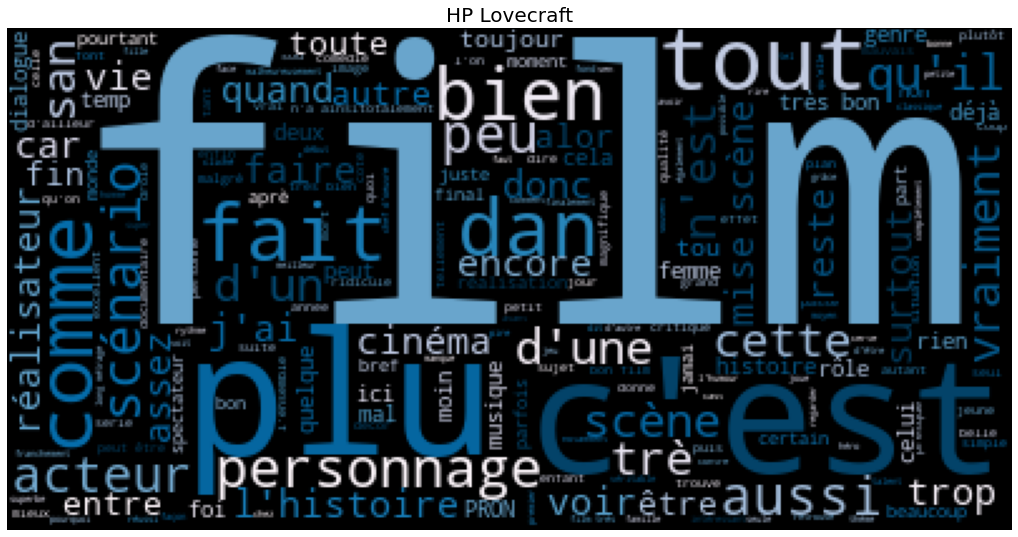

In [ ]:
#Nuage d'entraînnement
def word_count(data):
   # Nuage de mots positifs et négatifs les plus représentés dans les textes
   wc = WordCloud(background_color="black",max_font_size=150, random_state=42)

   plt.figure(figsize=(18,16))

   #génération word cloud
   wc.generate(" ".join(data["Review"]))

   plt.title("HP Lovecraft", fontsize=20)
   plt.imshow(wc.recolor(colormap= 'PuBu' , random_state=17))
   plt.axis('off')
  
word_count(train)

#### fréquence de distribution et nuage de mots  du test

In [ ]:
#fréquence de distribution entre les critiques positives et négatives de l'enssemble de test
print(pd.crosstab(index=test["Label"],columns="count"))

col_0  count
Label       
0      10408
1       9592


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


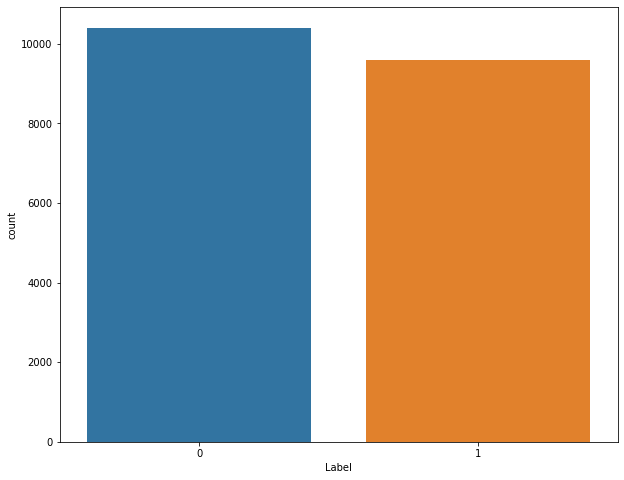

In [ ]:
plot , ax = plt.subplots(figsize=(10,8))
sns.countplot(test["Label"])

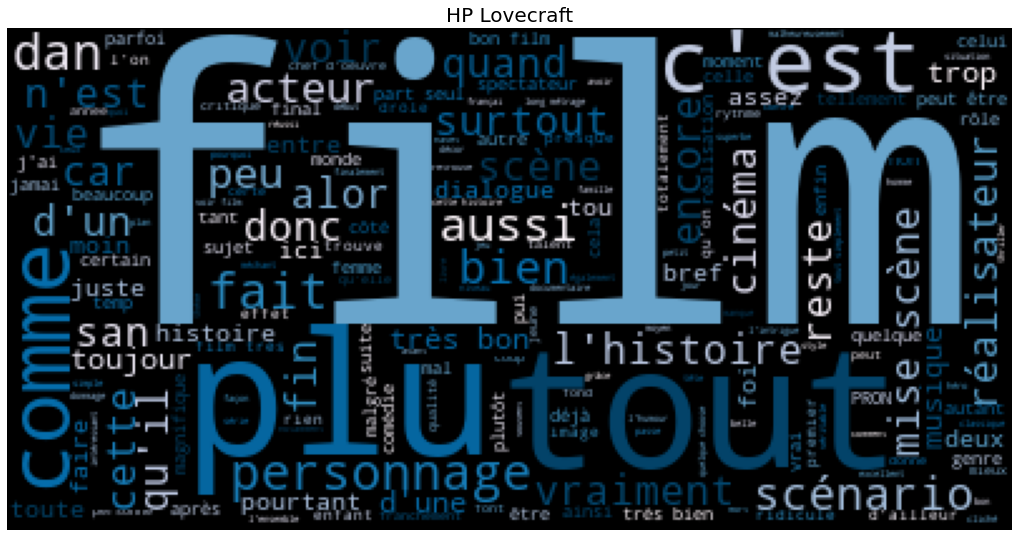

In [ ]:
# Nuage de mots positifs et négatifs les plus représentés dans les textes
word_count(test)

on crée notre ensemble d'apprentissage et de validation à partir de train

#### Top 50 mots des deux ensembles

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

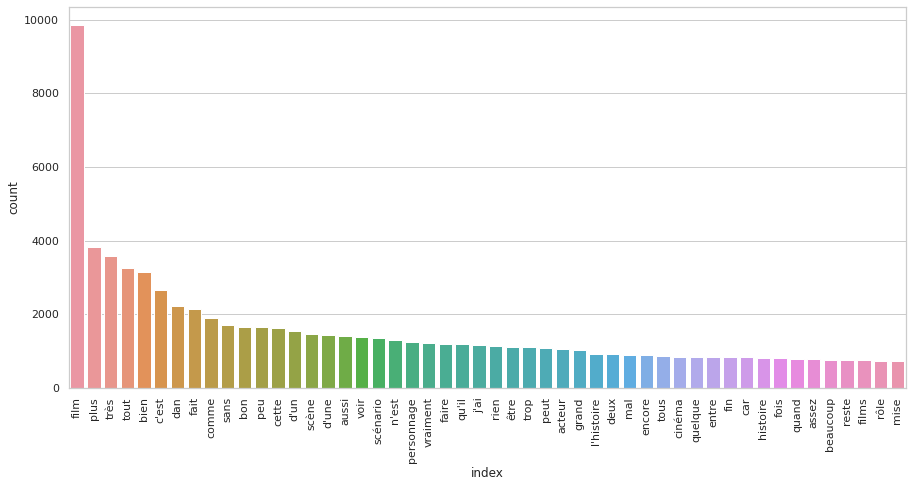

In [ ]:
#Top 50 mots du train
all_words = train["Review"].str.split()
merged = list(chain(*all_words))
d = Counter(merged)
df = pd.DataFrame(data=d, index=['count'])
top_words = df.T.sort_values(by=['count'], ascending=False).reset_index().head(50)
plt.figure(figsize=(15,7))
sns.set(style="whitegrid")
sns.barplot(x="index", y='count', data=top_words)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

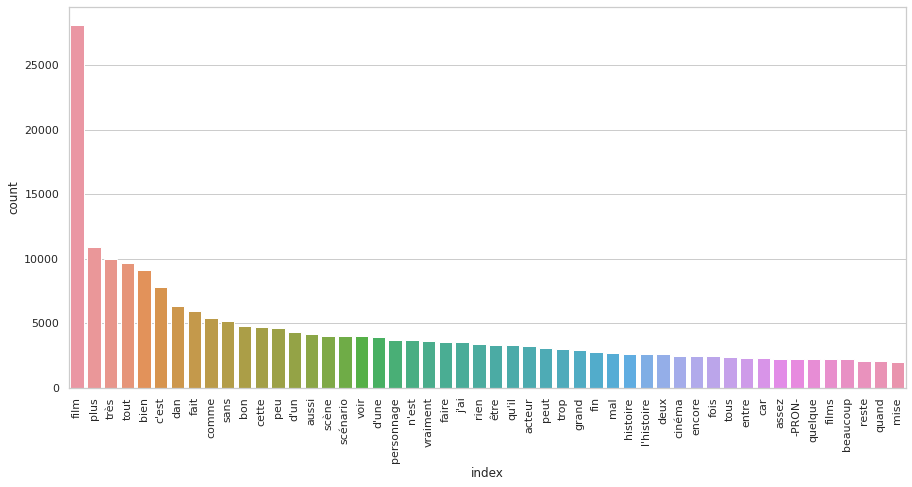

In [ ]:
#Top 50 mots du test
all_words = test["Review"].str.split()
merged = list(chain(*all_words))
d = Counter(merged)
df = pd.DataFrame(data=d, index=['count'])
top_words = df.T.sort_values(by=['count'], ascending=False).reset_index().head(50)
plt.figure(figsize=(15,7))
sns.set(style="whitegrid")
sns.barplot(x="index", y='count', data=top_words)
plt.xticks(rotation=90)

On voit que les mots les plus fréquents et communs aux deux ensembles se jouent entre:


*   film
*   plus
*   très
*   tout
*   bien

In [ ]:
data_train, data_val= train_test_split(train,train_size=0.75,stratify=train['Label'])

In [ ]:
#Fréquence de distribution du type de critique
#train set
print("Train set:")
freqTrain = pd.crosstab(index=data_train["Label"],columns="count")
print(freqTrain/freqTrain.sum())

#test set
print("Validation set:")
freqTest = pd.crosstab(index=data_val["Label"],columns="count")
print(freqTest/freqTest.sum())

Train set:
col_0     count
Label          
0      0.502476
1      0.497524
Validation set:
col_0     count
Label          
0      0.502857
1      0.497143


les proportions sont bien respectées

## Modèlisation

### logistic regression 

In [ ]:
#On instancie l'object pour parser avec la pondération binaire
parseur= CountVectorizer(binary=True)

#Création de la matrice terme document
XTrain = parseur.fit_transform(data_train['Review'])

#transform the sparse matrix into a numpy matrix
mdtTrain = XTrain.toarray()

In [ ]:
#On initie et instancie la classe de la logistic regression
modelFirst = LogisticRegression(max_iter=500)

#Lance l'entraînement avec la fonction fit
modelFirst.fit(mdtTrain,data_train['Label'])

LogisticRegression(max_iter=500)

In [ ]:
#taille de la matrice à coefficient
print(modelFirst.coef_.shape)

#constante du modèle
print(modelFirst.intercept_)

(1, 31263)
[-0.61802408]


#### Evaluation sur la validation

In [ ]:
#création de la matrice term document à partir du parseur crée plus haut pour avoir le même nombre de tokens différents
mdtVal = parseur.transform(data_val['Review'])

#taille de la matrice 
print(mdtVal.shape)

(1750, 31263)


In [ ]:
#prédiction du corpus de test
predVal = modelFirst.predict(mdtVal)

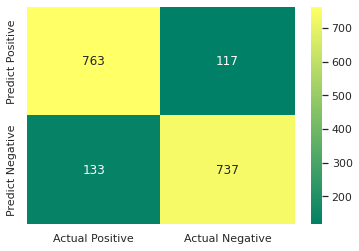

In [ ]:

def plt_acc(mc):
  cm_matrix = pd.DataFrame(data=mc, columns=['Actual Positive', 'Actual Negative'], 
                        index=['Predict Positive', 'Predict Negative'])
  sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='summer')
  plt.show()

plt_acc(metrics.confusion_matrix(data_val['Label'],predVal))

In [ ]:

#recall
print(f"recall <---->  {metrics.recall_score(data_val['Label'],predVal,pos_label=1)}")

#precision
print(f"precision <----> {metrics.precision_score(data_val['Label'],predVal,pos_label=1)}")

#F1-Score
print(f"F1-Score <----> {metrics.f1_score(data_val['Label'],predVal,pos_label=1)}")

#accuracy rate
print(f"accuracy rate <----> {metrics.accuracy_score(data_val['Label'],predVal)}")

recall <---->  0.8471264367816091
precision <----> 0.8629976580796253
F1-Score <----> 0.8549883990719258
accuracy rate <----> 0.8571428571428571


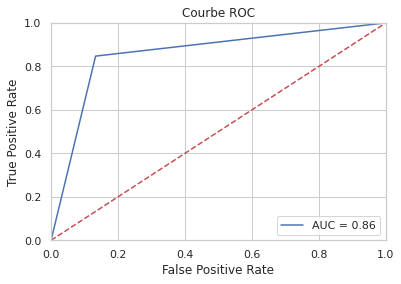

In [ ]:
#ROC
def ROC(pred,data):
  fpr, tpr, threshold = metrics.roc_curve(data, pred)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Courbe ROC')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
#Roc
ROC(predVal,data_val['Label'])

#### Evaluation sur l'ensemble de test

In [ ]:
#création de la matrice term document à partir du parseur crée plus haut pour avoir le même nombre de tokens différents
mdtTest = parseur.transform(test['Review'])

#taille de la matrice 
print(mdtTest.shape)

#prédiction du corpus de test
predTest = modelFirst.predict(mdtTest)

(20000, 31263)


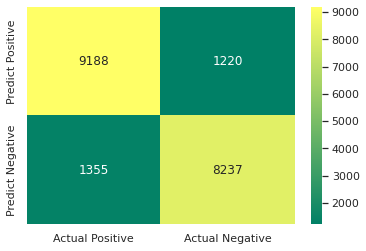

In [ ]:
#confusion matrix
plt_acc(metrics.confusion_matrix(test['Label'],predTest))

In [ ]:

#recall
print(f"recall <---->  {metrics.recall_score(test['Label'],predTest,pos_label=1)}")

#precision
print(f"precision <----> {metrics.precision_score(test['Label'],predTest,pos_label=1)}")

#F1-Score
print(f"F1-Score <----> {metrics.f1_score(test['Label'],predTest,pos_label=1)}")

#accuracy rate
print(f"accuracy rate <----> {metrics.accuracy_score(test['Label'],predTest)}")

recall <---->  0.8697873227689742
precision <----> 0.8752622744439782
F1-Score <----> 0.8725162099979085
accuracy rate <----> 0.8781


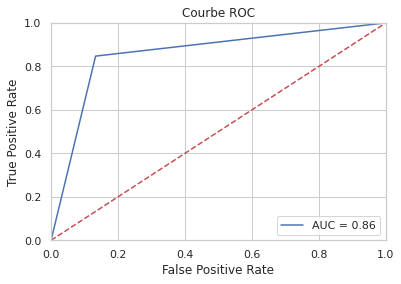

In [ ]:
ROC(predVal,data_val['Label'])

Conclusion: en regardant l'accuracy et la matrice de confusion, on voit que le modèle est plutôt bon, mais on a quand même 6.8% de faux positifs et 6% de faux négatifs. On rappelle également qu'on a train notre modèle sur un sous-échantillon de notre dataset de train de départ pour que le train fonctionne, ce qui a dû affecter les performances du modèle: avec plus données il aurait mieux appris (tout en faisant attention à ne pas non plus basculer dans de l'overfitting)

### Tests sur d'autres algos

### Vectoriseur TfIdf et un Naïve Bayésien (version multinomial)

In [ ]:
from nltk.tokenize.casual import TweetTokenizer
t = TweetTokenizer()
stop_words_fr = stopwords.words('french')
exclude_ponctuation = set(string.punctuation)
stop_words_fr.extend(exclude_ponctuation)
stop_words_fr.extend(["...","’"])

on utilise ici le même ensemble de stop words avec lequel on a travaillé dans la première partie

In [ ]:
#On reconstruit un parseur avec l'option : stop_words=stop_words_fr et l'analyzer = word
vect = TfidfVectorizer(stop_words=stop_words_fr, analyzer="word")
XTrainNB = vect.fit_transform(data_train['Review'])

#nombre de tokens différents
print(len(vect.get_feature_names()))

#matrice de document term
mdtTrainNB = XTrainNB.toarray()

#initialisation the object
NB_clf = MultinomialNB()

#entraînement du model
NB_clf.fit(mdtTrainNB, data_train["Label"])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


31178


MultinomialNB()



#### Evaluation sur validation

In [ ]:
print("Evaluation sur validation: ")
#Evaluation du corpus de test
XTestNB = vect.transform(data_val["Review"])
predicted = NB_clf.predict(XTestNB)

#Affichage des résultats (matrice de confusion, précision, rappel..)
# print(metrics.confusion_matrix(data_val['Label'],predicted))
print(metrics.classification_report(data_val["Label"], predicted))
print("Accuracy: ",metrics.accuracy_score(data_val['Label'],predicted))

Evaluation sur validation: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       880
           1       0.88      0.89      0.88       870

    accuracy                           0.88      1750
   macro avg       0.88      0.88      0.88      1750
weighted avg       0.88      0.88      0.88      1750

Accuracy:  0.8822857142857143


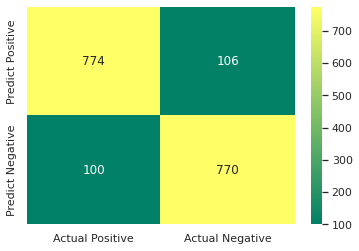

In [ ]:
#confusion matrix
plt_acc(metrics.confusion_matrix(data_val['Label'],predicted))

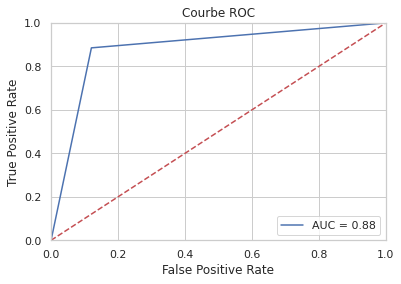

In [ ]:
#ROC
ROC(predicted ,data_val['Label'])

#### Evaluation sur test

In [ ]:
print("Evaluation sur test: ")
#Evaluation du corpus de test
XTestNB = vect.transform(test["Review"])
predicted = NB_clf.predict(XTestNB)

#Affichage des résultats (matrice de confusion, précision, rappel..)
# print(metrics.confusion_matrix(test['Label'],predicted))
print(metrics.classification_report(test["Label"], predicted))
print("Accuracy: ",metrics.accuracy_score(test['Label'],predicted))

Evaluation sur test: 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     10408
           1       0.89      0.89      0.89      9592

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000

Accuracy:  0.89


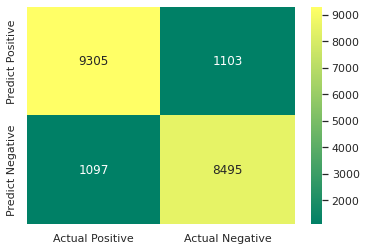

In [ ]:
#confusion matrix
plt_acc(metrics.confusion_matrix(test['Label'],predicted))

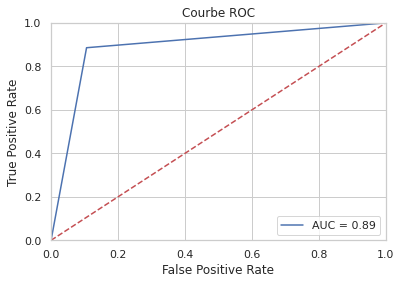

In [ ]:
#ROC
ROC(predicted ,test['Label'])

Conclucsion: les performances de ce modèle sont légèrement meilleures que le précédent, on a ici moins de faux positifs et négatifs

### NBA avec CountVectoriser

In [ ]:
from nltk.tokenize.casual import TweetTokenizer
t = TweetTokenizer()
stop_words_fr = stopwords.words('french')
exclude_ponctuation = set(string.punctuation)
stop_words_fr.extend(exclude_ponctuation)
stop_words_fr.extend(["...","’"])

def tok_sentence(sentence):
  res = []
  res.extend(t.tokenize(sentence.lower()))
  res = [word for word in res if word not in stop_words_fr]
  return res

In [ ]:
#On reconstruit un parseur avec l'option : stop_words=stop_words_fr et la nouvelle fonction en analyzer
vect2 = CountVectorizer(stop_words=stop_words_fr, tokenizer=tok_sentence, binary=True)
XTrainNB2 = vect2.fit_transform(data_train['Review'])

#nombre de tokens différents
print("nombre de feature: ", len(vect2.get_feature_names()))

#matrice de document term
mdtTrainNB2 = XTrainNB2.toarray()

#initialisation the object
NB_clf2 = MultinomialNB()

#entraînement du model
NB_clf2.fit(mdtTrainNB2, data_train["Label"])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


nombre de feature:  34093


MultinomialNB()

On a ici plus de tokens différents qu'avant

#### Evaluation sur validation

In [ ]:
print("Evaluation sur validation: ")

#Evaluation du corpus de test
XTestNB2 = vect2.transform(data_val["Review"])
predicted2 = NB_clf2.predict(XTestNB2)

#Affichage des résultats (matrice de confusion, précision, rappel..)
# print("matrice de confusion: ",metrics.confusion_matrix(data_val['Label'],predicted2))
print(metrics.classification_report(data_val["Label"], predicted2))
print("Accuracy: ",metrics.accuracy_score(data_val['Label'],predicted2))

Evaluation sur validation: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       880
           1       0.88      0.88      0.88       870

    accuracy                           0.88      1750
   macro avg       0.88      0.88      0.88      1750
weighted avg       0.88      0.88      0.88      1750

Accuracy:  0.8765714285714286


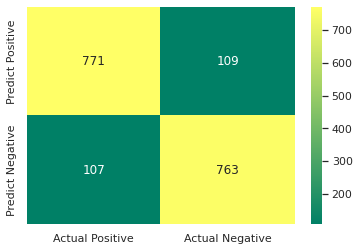

In [ ]:
#confusion matrix
plt_acc(metrics.confusion_matrix(data_val['Label'],predicted2))

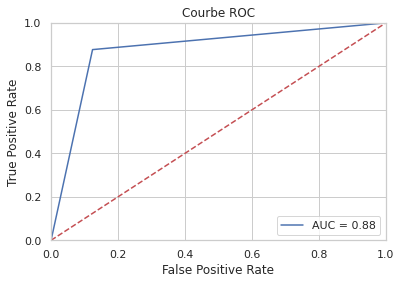

In [ ]:
#ROC
ROC(predicted2,data_val["Label"])

#### Evaluation sur test

In [ ]:
print("Evaluation sur test: ")

#Evaluation du corpus de test
XTestNB2 = vect2.transform(test["Review"])
predicted2 = NB_clf2.predict(XTestNB2)

#Affichage des résultats (matrice de confusion, précision, rappel..)
# print("matrice de confusion: ",metrics.confusion_matrix(test['Label'],predicted2))
print(metrics.classification_report(test["Label"], predicted2))
print("Accuracy: ",metrics.accuracy_score(test['Label'],predicted2))

Evaluation sur test: 
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     10408
           1       0.89      0.88      0.88      9592

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000

Accuracy:  0.88905


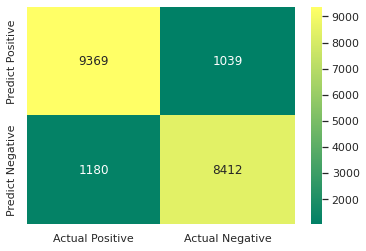

In [ ]:
#confusion matrix
plt_acc(metrics.confusion_matrix(test['Label'],predicted2))

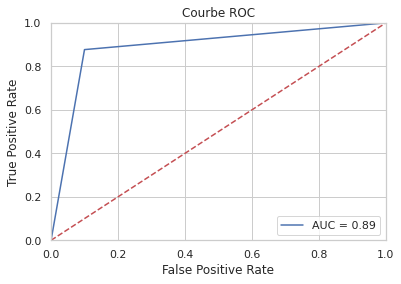

In [ ]:
#ROC
ROC(predicted2,test["Label"])

On voit une très légère diminution des performances

#### Exemples

Testons un exemple de critique au hasard et regardons si elle est bien catégorisée

In [ ]:
review_test = ["ce film est très intéressant, les acteurs livrent de belles performances"]

#On veut savoir comment est vectorisé cet exemple avec le transformer qu'on a initié toute à l'heure
mat_reviewTest = vect2.transform(review_test)
print(mat_reviewTest)

  (0, 692)	1
  (0, 2920)	1
  (0, 12197)	1
  (0, 15805)	1
  (0, 18658)	1
  (0, 23237)	1
  (0, 31867)	1


In [ ]:
#Mais de quels termes s'agit-il ? 
print(np.asarray(vect2.get_feature_names())[mat_reviewTest.indices])

['acteurs' 'belles' 'film' 'intéressant' 'livrent' 'performances' 'très']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
predicted2 = NB_clf2.predict(mat_reviewTest)
print(predicted2)

[1]


Essayons encore une fois

In [ ]:
review_test = ["le scénario n'était pas à la hauteur, tout comme le rythme trop mou de l'ensemble du film"]

#On veut savoir comment est vectorisé cet exemple avec le transformer qu'on a initié toute à l'heure
mat_reviewTest = vect2.transform(review_test)
print(mat_reviewTest)

print(np.asarray(vect2.get_feature_names())[mat_reviewTest.indices])

predicted2 = NB_clf2.predict(mat_reviewTest)
print(predicted2)

  (0, 5619)	1
  (0, 12197)	1
  (0, 14208)	1
  (0, 17340)	1
  (0, 20771)	1
  (0, 21406)	1
  (0, 27230)	1
  (0, 28709)	1
  (0, 31431)	1
  (0, 31785)	1
['comme' 'film' 'hauteur' "l'ensemble" 'mou' "n'était" 'rythme' 'scénario'
 'tout' 'trop']
[0]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Nos deux exemples ont bien été catégorisés

### On reprend la Logistic Regression mais en faisant un TFIDF

In [ ]:
#initialisation the object
LogReg_clf = LogisticRegression()

#entraînement du model
LogReg_clf.fit(mdtTrainNB, data_train["Label"])

#Evaluation du corpus de test
predicted_Log = LogReg_clf.predict(XTestNB)

#Affichage des résultats (matrice de confusion, précision, rappel..)
# print(metrics.confusion_matrix(test['Label'],predicted_Log))
print(metrics.classification_report(test["Label"], predicted_Log))
print("Accuracy: ",metrics.accuracy_score(test['Label'],predicted_Log))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     10408
           1       0.88      0.89      0.89      9592

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000

Accuracy:  0.8897


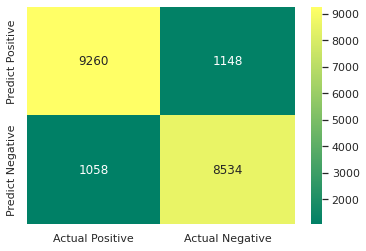

In [ ]:
#confusion matrix
plt_acc(metrics.confusion_matrix(test['Label'],predicted_Log))

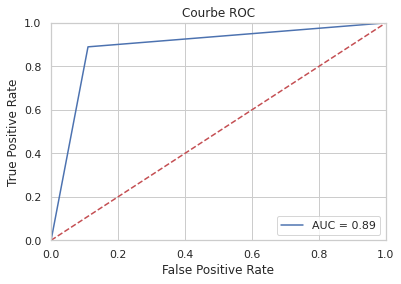

In [ ]:
#ROC
ROC(predicted_Log,test['Label'])

Résultats améliorantes

On a bcp de features, on va regarder comment le modèle se comporte lorsqu'on diminue le nb de features grâce à min_df

In [ ]:
#on reconstruit le parseur avec des nouvelles options: stop_words=stop_words_fr and min_df = 10
parseur3 = CountVectorizer(stop_words=stop_words_fr,binary=True, min_df = 10)
XTrain3 = parseur3.fit_transform(data_train['Review'])

#nombre de token différents
print(len(parseur3.get_feature_names()))

#document term matrice
mdtTrain3 = XTrain3.toarray()

#initie l'objet
model_logreg3 = LogisticRegression()

#entraînement du model
model_logreg3.fit(mdtTrain3,data_train['Label'])

#création de la matrice document/term pour le corpus de test
mdtTest3 = parseur3.transform(test['Review'])

#prediction pour le corpus de test
predTest3 = model_logreg3.predict(mdtTest3)

#Affichage des résultats (matrice de confusion, précision, rappel..)
# print("matrice de confusion: ",metrics.confusion_matrix(test['Label'],predTest3))
print(metrics.classification_report(test["Label"], predTest3))
print("Accuracy: ",metrics.accuracy_score(test['Label'],predTest3))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


3624
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     10408
           1       0.87      0.86      0.87      9592

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Accuracy:  0.8734


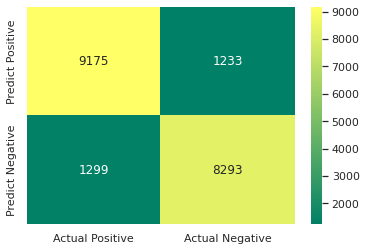

In [ ]:
#confusion matrix
plt_acc(metrics.confusion_matrix(test['Label'],predTest3))

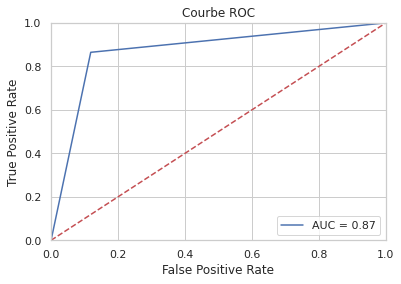

In [ ]:
#ROC
ROC(predTest3 ,test['Label'])

On remarque que le nb de features a largement diminué (divisé par 10), mais les prédictions du modèle sont légèrement moins bonnes. Cependant on est largement gagnant dans un cotexte d'un modèle sur un très grands nombre de données même si la qualité est faiblement diminuée et que le nb de features est divisé par 10, les couts computationnels étant une problématique importante, on est alors gagnant. 

### Test avec un SVM

In [ ]:
XTrainSVM = vect.fit_transform(data_train['Review'])
XTestSVM = vect.transform(test['Review'])

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(XTrainSVM,data_train["Label"])
predictions_SVM = SVM.predict(XTestSVM)
print(metrics.classification_report(test["Label"], predictions_SVM))
print("Accuracy: ",metrics.accuracy_score(test['Label'],predictions_SVM))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     10408
           1       0.88      0.89      0.88      9592

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000

Accuracy:  0.8863


Pas d'augmentation conséquente

### Deep Neural Networks

In [ ]:
import numpy as np
import pandas as pd
from numpy import mean 
from numpy import std 
import matplotlib.pyplot as plt
import seaborn as sns
 
import pickle 
import keras 
import tensorflow as tf 
import livelossplot 

from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.metrics import accuracy_score 
# from sklearn.cluster import KMeans 

from sklearn.datasets import make_classification 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
# from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB 
from sklearn.manifold import TSNE

from matplotlib import pyplot 

from sklearn.model_selection import train_test_split 
# from sklearn.ensemble import RandomForestRegressor 

from keras.models import Sequential 
from keras.layers import Activation, Dense 
from keras.layers import Dense, Dropout, Flatten 
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# from plot_keras_history import show_history, plot_history
# from tensorflow.keras import regularizers
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from tensorflow.python.client import device_lib

from array import array

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import os
# print(os.listdir("../input"))
plt.style.use('ggplot')

In [ ]:
!pip install livelossplot
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=d182b901e8de9190b216880f05eaf26cf2ec52945081187293e3c14ffb9a810d
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=bab183d74b9cc5bb198df21a05d54fdbe2f5d8d190c28a792e03f9d087eba14c
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=ae1226bdd330d5c9adec36807d1bf8c691ece8f716de3df4011bc7ff389c8a7a
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [ ]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15587352310099046119
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10831593472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6307289098383612919
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
GPU_list = tf.config.list_physical_devices('GPU')

In [ ]:
GPU_list

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(data_train['Review'].values)
X_train = vectorizer.transform(data_train['Review'].values)
X_test  = vectorizer.transform(test['Review'].values)

y_train=data_train["Label"].values
y_test=test["Label"].values

#### Keras Model
Keras est une API d'apprentissage profond et de réseaux neuronaux créés par François Chollet.
Elle est capable de résoudre les problèmes de classification des NLP.
Notre modèle utilise deux couches denses.
il prend en entrée input dim features et renvoie une sortie

In [ ]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 10)                312640    
                                                                 
 dense_27 (Dense)            (None, 1)                 11        
                                                                 
Total params: 312,651
Trainable params: 312,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_12/dense_26/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_12/dense_26/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_12/dense_26/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


525/525 [==============================] - 13s 22ms/step - loss: 0.4347 - accuracy: 0.8360 - val_loss: 0.3237 - val_accuracy: 0.8781
Epoch 2/100
525/525 [==============================] - 11s 22ms/step - loss: 0.1428 - accuracy: 0.9646 - val_loss: 0.2827 - val_accuracy: 0.8903
Epoch 3/100
525/525 [==============================] - 12s 22ms/step - loss: 0.0674 - accuracy: 0.9891 - val_loss: 0.2919 - val_accuracy: 0.8874
Epoch 4/100
525/525 [==============================] - 11s 22ms/step - loss: 0.0374 - accuracy: 0.9958 - val_loss: 0.3088 - val_accuracy: 0.8878
Epoch 5/100
525/525 [==============================] - 11s 21ms/step - loss: 0.0224 - accuracy: 0.9970 - val_loss: 0.3331 - val_accuracy: 0.8860
Epoch 6/100
525/525 [==============================] - 11s 22ms/step - loss: 0.0145 - accuracy: 0.9989 - val_loss: 0.3622 - val_accuracy: 0.8836
Epoch 7/100
525/525 [==============================] - 11s 22ms/step - loss: 0.0099 - accuracy: 0.9990 - val_loss: 0.3922 - val_accuracy: 0.88

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9998
Testing Accuracy:  0.8424


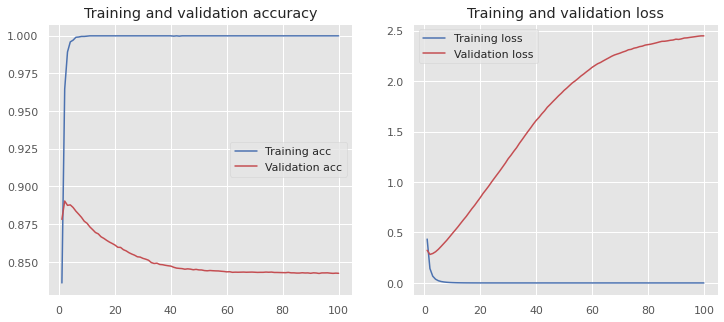

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

Le modèle est meilleure 

#### Keras TSNE

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(data_train['Review'].values)
X_train = vectorizer.transform(data_train['Review'].values)
X_test  = vectorizer.transform(test['Review'].values)

y_train=data_train["Label"].values
y_test=test["Label"].values

In [ ]:
X_train_2d=tsne.fit_transform(X_train)
X_test_2d=tsne.fit_transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[Text(0.5, 1.0, ' t-SNE projection')]

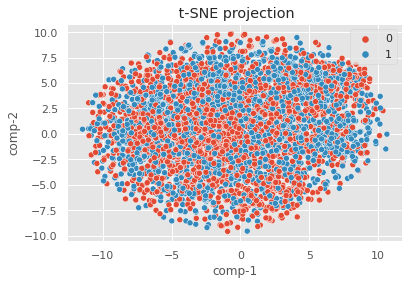

In [ ]:
df = pd.DataFrame()
df["comp-1"] = X_train_2d[:,0]
df["comp-2"] = X_train_2d[:,1]
df["y"] = y_train

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),data=df).set(title=" t-SNE projection")

In [ ]:
input_dim = X_train_2d.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                30        
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train_2d, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test_2d, y_test),
                    batch_size=10)

Epoch 1/100
525/525 [==============================] - 104s 195ms/step - loss: 0.7254 - accuracy: 0.5404 - val_loss: 0.8453 - val_accuracy: 0.4392
Epoch 2/100
525/525 [==============================] - 7s 13ms/step - loss: 0.6887 - accuracy: 0.5625 - val_loss: 0.7810 - val_accuracy: 0.4527
Epoch 3/100
525/525 [==============================] - 6s 11ms/step - loss: 0.6868 - accuracy: 0.5623 - val_loss: 0.7400 - val_accuracy: 0.4475
Epoch 4/100
525/525 [==============================] - 7s 13ms/step - loss: 0.6860 - accuracy: 0.5672 - val_loss: 0.7632 - val_accuracy: 0.4424
Epoch 5/100
525/525 [==============================] - 7s 13ms/step - loss: 0.6851 - accuracy: 0.5636 - val_loss: 0.7551 - val_accuracy: 0.4568
Epoch 6/100
525/525 [==============================] - 5s 10ms/step - loss: 0.6840 - accuracy: 0.5651 - val_loss: 0.7931 - val_accuracy: 0.4236
Epoch 7/100
525/525 [==============================] - 7s 13ms/step - loss: 0.6837 - accuracy: 0.5638 - val_loss: 0.7653 - val_accura

In [ ]:
loss, accuracy = model.evaluate(X_train_2d, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_2d, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5899
Testing Accuracy:  0.4979


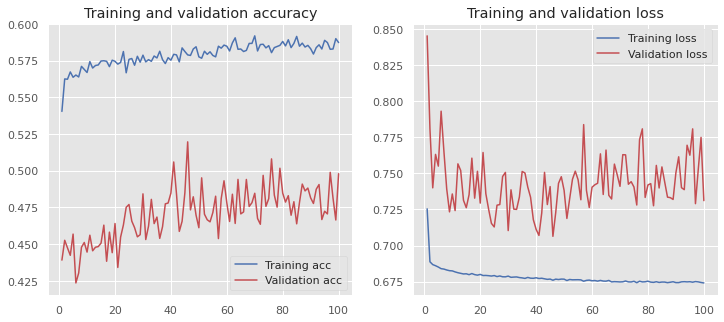

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

On espérait un résultat conséquent mais cela n'est pas le cas, le modèle PCA n'est pas adapté à résoudre ce type de problème.
Underfitting

## Conclusion

Le choix du méthode de transformation et modèle se joue entre :
* Vectoriseur TfIdf et un Naïve Bayésien (version multinomial)
* Logistic Regression mais en faisant un TFIDF
* Keras Model sans PCA 

Le choix de la méthode et de la transformation est très important dans la construcction d'un bon modèle.